# Lab 4 -- Spectral Clustering
* Paper: [On Spectral Clustering: Analysis and an algorithm](http://ai.stanford.edu/~ang/papers/nips01-spectral.pdf)

In [1501]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import sqrtm, eigh
import pandas as pd
import networkx as nx

# Warm-up

> **Lab description**:  As a warm-up task, you should first compute the eigenvectors and eigenvalues of a set of graphs and find out how many communities these graphs have. 

We include the warm-up too, and we'll perform the eigendecomposition on the test graph.

In [1502]:
test = './data/test.dat'

Let's store the data in a Pandas DataFrame.

In [1503]:
df = pd.read_csv(test)
df['weight'] = 1
df

,from,to,weight
0,1,2,1
1,1,3,1
2,2,1,1
3,2,3,1
4,2,4,1
5,3,1,1
6,3,2,1
7,4,2,1
8,4,5,1
9,4,6,1


We'll keep a high level of abstraction by using the Python library `networkx` to create the graph. It actually has several of useful functions for graph analysis, but we'll just use it for the graph creation and plotting.

In [1504]:
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])

In [1505]:
A = nx.to_numpy_matrix(G)
pd.DataFrame(points, dtype=int)

,0,1,2,3,4,5
0,0,1,1,0,0,0
1,1,0,1,1,0,0
2,1,1,0,0,0,0
3,0,1,0,0,1,1
4,0,0,0,1,0,1
5,0,0,0,1,1,0


Now I use numpy to find the eigenvalues and eigenvectors of the sparse matrix.

`LA.eigh(A)` returns:

* `eigvals`: a 1D array of eigenvalues
* `eigvecs`: a 2D array of normalized (unit "length) eigenvectors, so when picking the $k$ first eigenvectors, it is what is called $Y$ in the paper


In [1506]:
eigvals, eigvecs = LA.eigh(A)
print(pd.DataFrame(eigvals))
print(pd.DataFrame(eigvecs))

          0
0 -1.732051
1 -1.000000
2 -1.000000
3 -0.414214
4  1.732051
5  2.414214
          0             1             2         3         4         5
0 -0.229850  7.071068e-01  0.000000e+00 -0.353553 -0.444037  0.353553
1  0.627963 -3.330669e-16 -5.680648e-17  0.500000 -0.325058  0.500000
2 -0.229850 -7.071068e-01  5.680648e-17 -0.353553 -0.444037  0.353553
3 -0.627963 -4.996004e-16  3.697785e-32  0.500000  0.325058  0.500000
4  0.229850  2.775558e-16 -7.071068e-01 -0.353553  0.444037  0.353553
5  0.229850  2.775558e-16  7.071068e-01 -0.353553  0.444037  0.353553


That latter matrix is the normal eigenvectors, sorted according to the 1D vector above. That concludes the warmup, let's continue with the main task.

# Initial analysis

We are going to explore the two datasets by plotting them first.

## Read data and setup graphs

In [1507]:
example1 = './data/example1.dat'
example2 = './data/example2.dat'

# appending a weight column
df_example1 = pd.read_csv(example1)
df_example1['weight'] = 1

# already has a weight column
df_example2 = pd.read_csv(example2)

# create a graph from the data
G_example1 = nx.from_pandas_edgelist(df=df_example1, source='from', target='to', edge_attr=['weight'])
G_example2 = nx.from_pandas_edgelist(df=df_example2, source='from', target='to', edge_attr=['weight'])

## Draw graphs

To get a sense of how the data is structured, let's plot the graphs.

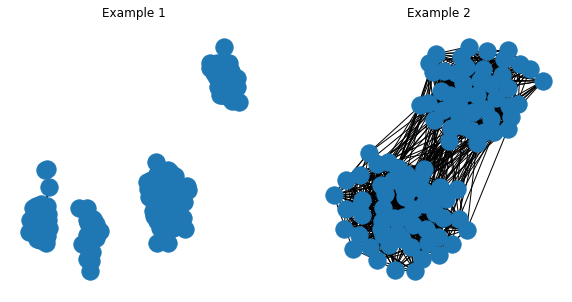

In [1508]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(G_example1, ax=axs[0])
nx.draw(G_example2, ax=axs[1])
axs[0].set_title('Example 1'); axs[1].set_title('Example 2');

# The algorithm
![image.png](imgs/algorithm.png)

Depending on how you find the eigenvectors, you may not need to do step 4. Scipy's `LA.eigh` returns the eigenvectors normalized and sorted by eigenvalue. First we'll perform all steps on the test data, then we'll collect them in a class and do the analysis on the main data.

## 1. Form the affinity matrix

In the article, Andrew Ng are using a set if points in some geometric space. We are using a graph, so we believe the affinity matrix is the adjacency matrix (which was later confirmed by the TA).

Again, read in the data and store it in a Pandas DataFrame.

In [1509]:
df = pd.read_csv(test)
df['weight'] = 1
df

,from,to,weight
0,1,2,1
1,1,3,1
2,2,1,1
3,2,3,1
4,2,4,1
5,3,1,1
6,3,2,1
7,4,2,1
8,4,5,1
9,4,6,1


Get the adjacency matrix.

In [1510]:
G = nx.from_pandas_edgelist(df=df, source='from', target='to', edge_attr=['weight'])
A = nx.to_numpy_matrix(G)
pd.DataFrame(A, dtype=int)

,0,1,2,3,4,5
0,0,1,1,0,0,0
1,1,0,1,1,0,0
2,1,1,0,0,0,0
3,0,1,0,0,1,1
4,0,0,0,1,0,1
5,0,0,0,1,1,0


# 2. Construct the Laplacian

We then construct the diagonal matrix `D` from the affinity matrix `A`, where `D[i,i] = sum(A[i,:])`.

In [1511]:
# NOTE np.diag is not working on my system for some reason, so doing this instead
D = np.zeros((len(A), len(A)))
for i in range(D.shape[0]):
    D[i,i] = A.sum(axis=1)[i]

pd.DataFrame(D)

,0,1,2,3,4,5
0,2.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0


And now we form the normalized Laplacian.

In [1512]:
L = ((sqrtm(inv(D))).dot(A)).dot(sqrtm(inv(D)))
pd.DataFrame(L)

,0,1,2,3,4,5
0,0.000000,0.408248,0.500000,0.000000,0.000000,0.000000
1,0.408248,0.000000,0.408248,0.333333,0.000000,0.000000
2,0.500000,0.408248,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.333333,0.000000,0.000000,0.408248,0.408248
4,0.000000,0.000000,0.000000,0.408248,0.000000,0.500000
5,0.000000,0.000000,0.000000,0.408248,0.500000,0.000000


# 3 Find the eigenvectors

Now we find the eigenvalues and eigenvectors of the adjacency matrix. Since it is symmetric, we use the python library `eigh`. 

* `eigvals=(len(L) - k - 1, len(L) - 1)` selects those eigenvectors we are interested in, the ones corresponding to the largest eigenvalues.

In [1513]:
from scipy.linalg import eigh

# number of clusters
k = 2

# find the k smallest eigenvalues and eigenvectors
eigvals, eigvecs = eigh(L, eigvals=(len(L) - k - 1, len(L) - 1))
print(pd.DataFrame(eigvals))
print(pd.DataFrame(eigvecs))

          0
0 -0.166667
1  0.795334
2  1.000000
          0         1         2
0 -0.327327 -0.445141 -0.377964
1  0.534522 -0.322023 -0.462910
2 -0.327327 -0.445141 -0.377964
3  0.534522  0.322023 -0.462910
4 -0.327327  0.445141 -0.377964
5 -0.327327  0.445141 -0.377964


# Step 4. Normalizing the eigenvectors
The eigenvectors are already sorted and normalized as per the Numpy implementation, so we can just take the first `k` of them.

In [1514]:
Y = eigvecs
pd.DataFrame(Y)

,0,1,2
0,-0.327327,-0.445141,-0.377964
1,0.534522,-0.322023,-0.462910
2,-0.327327,-0.445141,-0.377964
3,0.534522,0.322023,-0.462910
4,-0.327327,0.445141,-0.377964
5,-0.327327,0.445141,-0.377964


# Step 5. Clustering with K-means

In [1515]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k).fit(np.asarray(Y))

clusters = kmeans.labels_

# Step 6. Assigning each node to a cluster
Now, proceed with the assigning the original points (in our case, rows in the affinity matrix) to the clusters.

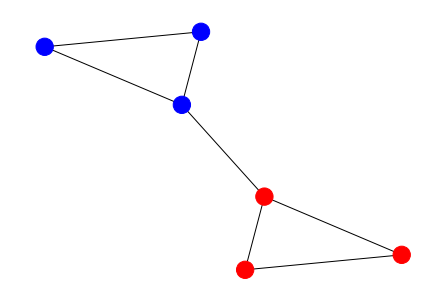

In [1516]:
colors = {0: 'red', 1: 'blue'}
nx.draw(G, node_color=[colors[cluster] for cluster in clusters])

# `SpectralClustering` class

In [1517]:
class SpectralClustering:
    def __init__(self, G, k=5):
        """
        Adjecency list is a networkx graph
        """
        self.G = G
        self.k = k
        self.clusters = None
        self.fiedler_vector = None

    def fit(self, adjecency_list):
        """
        This method runs the spectral clustering algorithm
        """
        # step 1
        self.A = nx.to_numpy_matrix(adjecency_list)
        # step 2    
        D = self.diy_diagonalize(self.A)
        L = ((sqrtm(inv(D))).dot(self.A)).dot(sqrtm(inv(D)))
        # step 3
        eigvals, eigvecs = eigh(L, eigvals=(len(L) - self.k - 1, len(L) - 1))
        # step 4
        # NOTE the eigenvectors are already normalized
        # step 5
        Y = eigvecs
        kmeans = KMeans(n_clusters=self.k).fit(np.asarray(Y))
        # step 6 is in the plot method
        # assign all instance fields
        self.L = L
        self.clusters = kmeans.labels_
        self.fiedler_vector = self.set_fiedler_vector()

    def normalize(self, matrix):
        """
        This method normalizes a matrix
        """
        return matrix / np.linalg.norm(matrix, axis=1)

    def diy_diagonalize(self, matrix):
        """
        I have the wrong np version so I can't use np.diag
        """
        D = np.zeros((len(self.A), len(self.A)))
        for i in range(D.shape[0]):
            D[i,i] = self.A.sum(axis=1)[i]
        return D

    def set_fiedler_vector(self):
        """
        This method sets the fiedler vector
        """
        # degree matrix
        D = self.diy_diagonalize(self.A)
        L = ((sqrtm(inv(D))).dot(self.A)).dot(sqrtm(inv(D)))
        eigvals, eigvecs = eigh(L)
        self.eigvecs = eigvecs
        return np.sort(eigvecs[:,1], axis=0)

    def number_of_components(self, threshold = 1e-10):
        """
        [From wiki] The number of times 0 appears as an eigenvalue in the Laplacian is the number of connected components in the graph
        """
        eigvals, _ = LA.eigh(self.L)
        return len([eigval for eigval in eigvals if eigval < threshold and eigval > -threshold])

    def plot_fiedler_vector(self):
        """
        This method plots the fiedler vector
        """
        plt.plot(self.fiedler_vector)
        plt.show()
    
    def plot(self):
        """
        Use nx.draw to plot the graph according to some colors
        """
        # The final step of the algorithm
        colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'gray', 6: 'yellow', 7: 'pink', 8: 'black', 9: 'brown', 10: 'cyan'}
        nx.draw(self.G, node_color=[colors[cluster] for cluster in self.clusters])
        plt.show()

## Example 1

Let's see if the class works with the data we have been provided.

In [1518]:
example1 = './data/example1.dat'

# requires us to append a weight column
df_g1 = pd.read_csv(example1)
df_g1['weight'] = 1

print("Number of unique nodes: ", df_g1['from'].nunique())

Number of unique nodes:  241


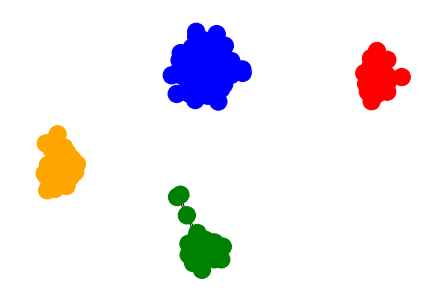

Number of components:  4


In [1519]:
# set up the graph
G1 = nx.from_pandas_edgelist(df=df_g1, source='from', target='to', edge_attr=['weight'])

# make a new spectral clustering object and fit the graph
sc = SpectralClustering(G=G1, k=4)
sc.fit(G1)

# plot and print the number of components
sc.plot()
print("Number of components: ", sc.number_of_components(threshold=0.005))

Looks quite nice! We also attempt to plot the sorted *Fiedler vector*, but it is not what we expected. According to theory, we should see a clear separation between the four clusters, but in our case it is not as visible as in the lab description's example.

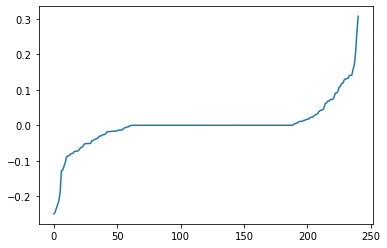

In [1520]:
sc.plot_fiedler_vector()

## Example 2

In [1521]:
example2 = './data/example2.dat'
df_g2 = pd.read_csv(example2)

print("Number of unique nodes: ", df_g2['from'].nunique())

Number of unique nodes:  100


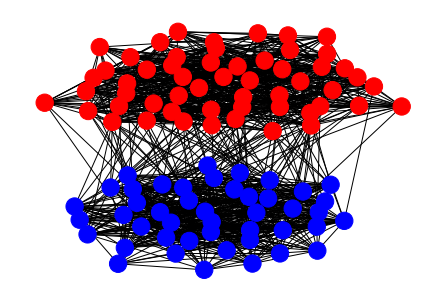

Number of components:  1


In [1522]:
# set up the graph
G2 = nx.from_pandas_edgelist(df=df_g2, source='from', target='to', edge_attr=['weight'])

# make a new spectral clustering object and fit the graph
sc = SpectralClustering(G=G2, k=2)
sc.fit(G2)

# plot and print the number of components
sc.plot()
print("Number of components: ", sc.number_of_components(threshold=1e-3))

Wow, the red and blue clusters are super-visible! Again, the fielder vector is not what we expected. We are not sure what is going on.

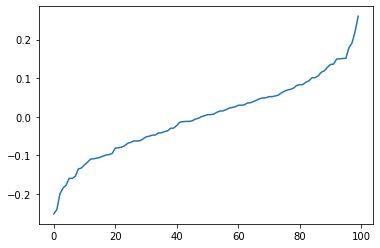

In [1523]:
sc.plot_fiedler_vector()